# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import json
import numpy as np
import pandas as pd
import pprint
import time
import yaml

from benchmarks.generator import get_revenue_behaviour
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 40


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
AVLO                    6
IRYO                   15
AVE                    11
OUIGO                   8
Total                  40


Services:  40


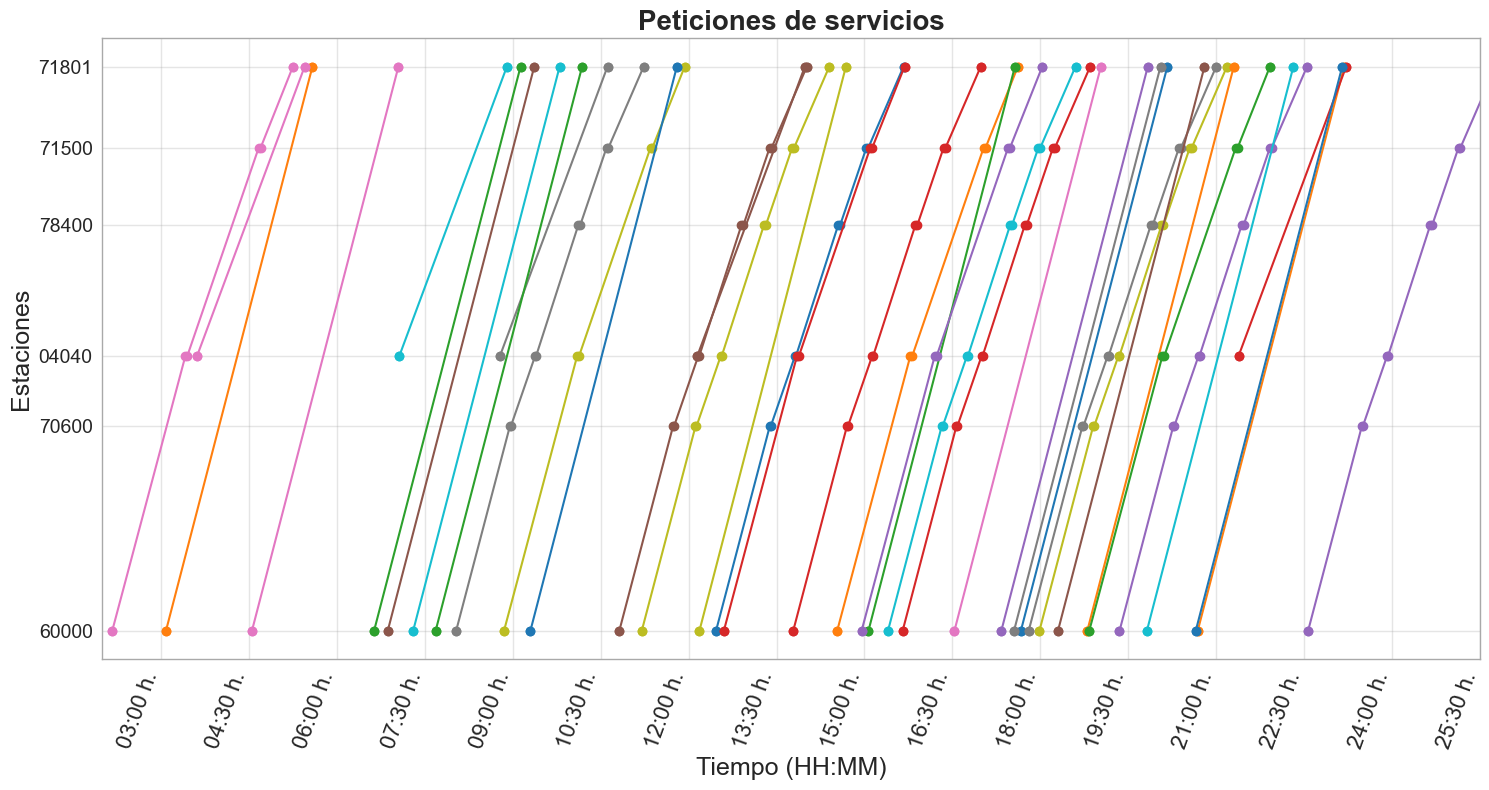

In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour(requested_schedule)
lines = supply.lines
line = infer_line_stations(lines)

plotter = TrainSchedulePlotter(requested_schedule, line)
plotter.plot(main_title="Peticiones de servicios")

In [6]:
#pr = profile.Profile()
#pr.enable()

def run_gsa(chaotic_constant: bool=False,
            runs: int=10,
            population_size: int=20,
            iters: int=50
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in tqdm(range(1, runs + 1)):
        sm = RevenueMaximization(requested_schedule=requested_schedule,
                                 revenue_behaviour=revenue_behaviour,
                                 line=line,
                                 safe_headway=10)
    
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
    
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iters,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=True,
                                             initial_population=sm.get_initial_population(population),
                                             verbose=verbosity,
                                             save_population=True)
    
        training_history.insert(0, "Run", r)
        training_history['Discrete'] = [sm.get_heuristic_schedule(Solution(real=r, discrete=np.array([]))) for r in training_history['Real']]
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        gsa_algo.population_history.insert(0, "Run", r)
        global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
        
    return global_train_hist, global_population_hist, runs_best_solution_history
        
#pr.disable()
#pr.dump_stats('profile.pstat')

In [7]:
runs = 5
population = 20
iters = 50
chaotic = True
verbosity = False

df_train_global, df_population, runs_best_solution_history = run_gsa(chaotic_constant=chaotic,
                                                                     runs=runs,
                                                                     population_size=population,
                                                                     iters=iters)

  0%|          | 0/5 [00:00<?, ?it/s]

## 1. Chaotic vs Normal GSA

In [8]:
runs = 5
population = 20
iters = 50

df_gcc = pd.DataFrame()
df_gpp = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    df_train, df_pop, _ = run_gsa(chaotic_constant=chaotic_constant,
                                  runs=runs,
                                  population_size=population,
                                  iters=iters)
    
    df_train["chaotic_constant"] = chaotic_constant
    df_gcc = pd.concat([df_gcc, df_train], axis=0)
    
    df_pop["chaotic_constant"] = chaotic_constant
    df_gpp = pd.concat([df_gpp, df_pop], axis=0)

Running GSA with chaotic constant:  True


  0%|          | 0/5 [00:00<?, ?it/s]

Running GSA with chaotic constant:  False


  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [11]:
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,real_11,real_12,real_13,real_14,real_15,real_16,real_17,real_18,real_19,chaotic_constant
0,1,0,4827.550956,4785.278898,4688.61099,4729.016619,4733.959366,4720.223617,4794.640037,4858.391303,...,4677.557694,4838.039629,4770.033239,4683.750642,4789.016746,4791.574272,4751.880917,4657.154304,4621.211733,True
1,1,1,4458.906064,4526.35909,4515.222998,4565.336287,4452.676368,4524.581399,4547.100717,4472.493771,...,4386.157126,4434.285732,4301.320463,4597.840967,4488.925549,4321.410087,4470.986174,4549.02462,4480.973961,True
2,1,2,4436.838831,4546.266507,4616.561147,4697.582555,4703.201529,4523.917681,4578.982482,4446.905069,...,4216.452428,4478.879531,4609.590518,4827.901944,4595.690304,4417.485337,4467.941092,4492.856027,4592.717694,True
3,1,3,4473.978918,4599.790299,4625.973014,4699.38829,4716.902515,4636.779991,4441.943509,4369.646942,...,4544.793604,4569.264957,4643.863689,4659.265782,4791.667323,4395.098161,4502.296736,4603.416103,4641.852292,True
4,1,4,4669.557872,4702.880019,4810.614907,4774.802238,4617.732343,4664.970466,4712.082022,4699.258779,...,4789.553203,4685.751182,4787.010137,4757.345196,4787.695248,4718.27276,4621.714284,4666.238347,4759.349852,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,5,45,4657.760348,4618.677913,4719.384449,4649.928487,4769.728081,4619.57327,4675.957602,4655.247278,...,4476.942238,4497.654548,4814.937037,4704.162975,4703.17186,4675.372242,4678.705594,4776.80809,4649.804294,False
46,5,46,4657.760348,4618.677913,4719.384449,4649.928487,4769.728081,4619.57327,4675.957602,4655.247278,...,4476.942238,4497.654548,4814.937037,4704.162975,4703.17186,4675.372242,4678.705594,4776.80809,4649.804294,False
47,5,47,4657.760348,4618.677913,4719.384449,4649.928487,4769.728081,4619.57327,4675.957602,4655.247278,...,4476.942238,4497.654548,4814.937037,4704.162975,4703.17186,4675.372242,4678.705594,4776.80809,4649.804294,False
48,5,48,4657.760348,4618.677913,4719.384449,4649.928487,4769.728081,4619.57327,4675.957602,4655.247278,...,4476.942238,4497.654548,4814.937037,4704.162975,4703.17186,4675.372242,4678.705594,4776.80809,4649.804294,False


In [12]:
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Chaotic,Individual
0,1,0,4827.550956,True,ID_real_0
1,1,0,4785.278898,True,ID_real_1
2,1,0,4688.610990,True,ID_real_2
3,1,0,4729.016619,True,ID_real_3
4,1,0,4733.959366,True,ID_real_4
...,...,...,...,...,...
9995,5,49,4703.171860,False,ID_real_15
9996,5,49,4675.372242,False,ID_real_16
9997,5,49,4678.705594,False,ID_real_17
9998,5,49,4776.808090,False,ID_real_18


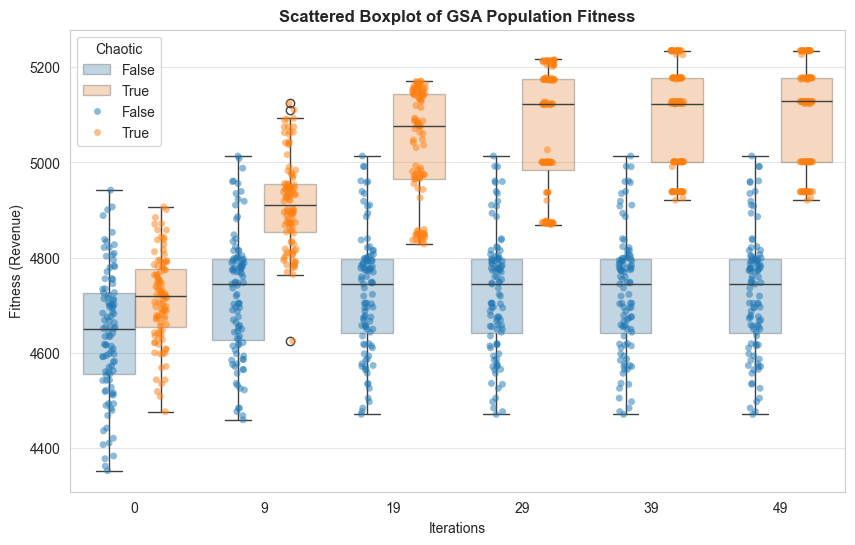

In [15]:
# Filter df only rows with 'Iteration' values in [0, 10, 20, 30, 40, 50]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 9, 19, 29, 39, 49])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Scattered Boxplot of GSA Population Fitness",
             x_label="Iterations",
             y_label="Fitness (Revenue)",
             save_path=Path('../figures/scattered_boxplot.pdf'))

In [21]:
df_gcc

,Run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real,chaotic_constant
0,1,0,4741.952226,0,0.137216,"[False, False, False, True, True, False, True,...","[1058, 862, 942, 1022, 910, 828, 891, 917, 962...",True
1,1,1,4858.391303,0,0.531627,"[False, False, False, True, True, False, True,...","[1060, 869, 948, 1030, 902, 827, 886, 915, 961...",True
2,1,2,4858.391303,0,0.927146,"[False, False, False, True, True, False, True,...","[1060, 869, 948, 1030, 902, 827, 886, 915, 961...",True
3,1,3,4858.391303,0,1.327223,"[False, False, False, True, True, False, True,...","[1060, 869, 948, 1030, 902, 827, 886, 915, 961...",True
4,1,4,4858.391303,0,1.730915,"[False, False, False, True, True, False, True,...","[1060, 869, 948, 1030, 902, 827, 886, 915, 961...",True
...,...,...,...,...,...,...,...,...
45,5,45,4815.875923,0,16.872112,"[False, True, False, True, True, True, True, T...","[1059, 869, 952, 1030, 909, 828, 885, 915, 963...",False
46,5,46,4815.875923,0,17.229823,"[False, True, False, True, True, True, True, T...","[1059, 869, 952, 1030, 909, 828, 885, 915, 963...",False
47,5,47,4815.875923,0,17.587023,"[False, True, False, True, True, True, True, T...","[1059, 869, 952, 1030, 909, 828, 885, 915, 963...",False
48,5,48,4815.875923,0,17.943728,"[False, True, False, True, True, True, True, T...","[1059, 869, 952, 1030, 909, 828, 885, 915, 963...",False


In [23]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
run_grouped_df = df_train_chaotic.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),AVE,OUIGO,IRYO,AVLO
1,2,5234.329365,18.858032,22,40.0,211.0,66.67 %,60.0 %,36.36 %,62.5 %
3,4,5177.261451,18.684964,21,19.0,261.0,66.67 %,53.33 %,36.36 %,62.5 %
2,3,5129.784845,18.697230,21,34.0,262.0,66.67 %,53.33 %,36.36 %,62.5 %
4,5,5029.069143,18.578843,20,58.0,234.0,66.67 %,46.67 %,36.36 %,62.5 %
0,1,4938.339857,18.801694,21,29.0,279.0,66.67 %,53.33 %,36.36 %,62.5 %


In [24]:
# Global status
print("Global GSA status:")

# Execution time (mean and std.)
run_times = run_grouped_df['ExecutionTime'].last()
print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')

# Revenue (mean and std.)
run_revenues = run_grouped_df['Fitness'].last()
print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')

# Scheduled trains (mean and std.)
run_trains = run_grouped_df['Discrete'].last().apply(sum)
print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')

runs_best_solution_history = dict(sorted(runs_best_solution_history.items(),
                                         key=lambda x: x[1][1]))

q2_solution_index = np.floor(runs // 2).astype(int)
gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]

print(f"\tMedian solution: Run {gsa_solution[0]}")
max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")

Global GSA status:
	Total execution time: 93.6208 s.
	Execution Time (by run) - Mean: 18.7242 s. - Std: 0.1088 s.
	Revenue - Mean: 5101.7569 - Std: 118.375
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Median solution: Run 4
	Max Revenue: 9267.5 - WARNING!: Scheduling all services could not be feasible


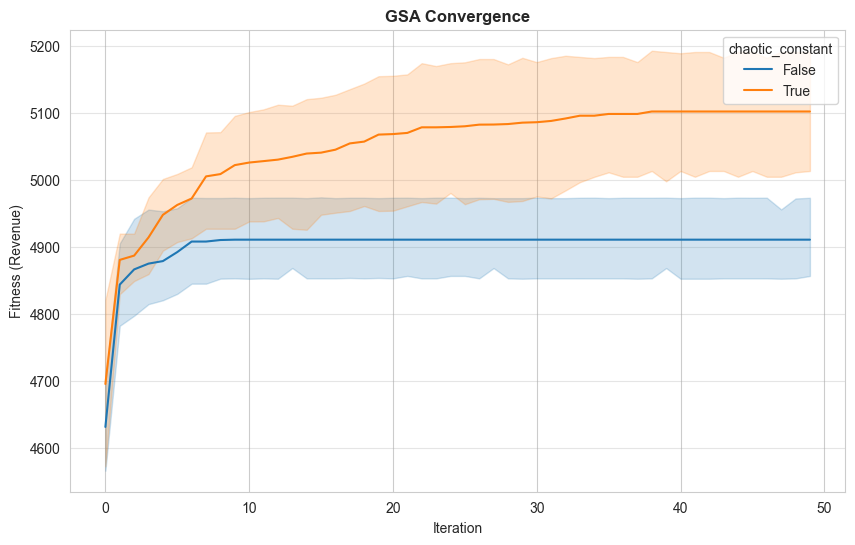

In [25]:
# GSA Convergence plot
sns_line_plot(df=df_gcc,
              x_data="Iteration",
              y_data="Fitness",
              hue="chaotic_constant",
              title="GSA Convergence",
              x_label="Iteration",
              y_label="Fitness (Revenue)",
              save_path=Path('../figures/gsa_convergence.pdf'))

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


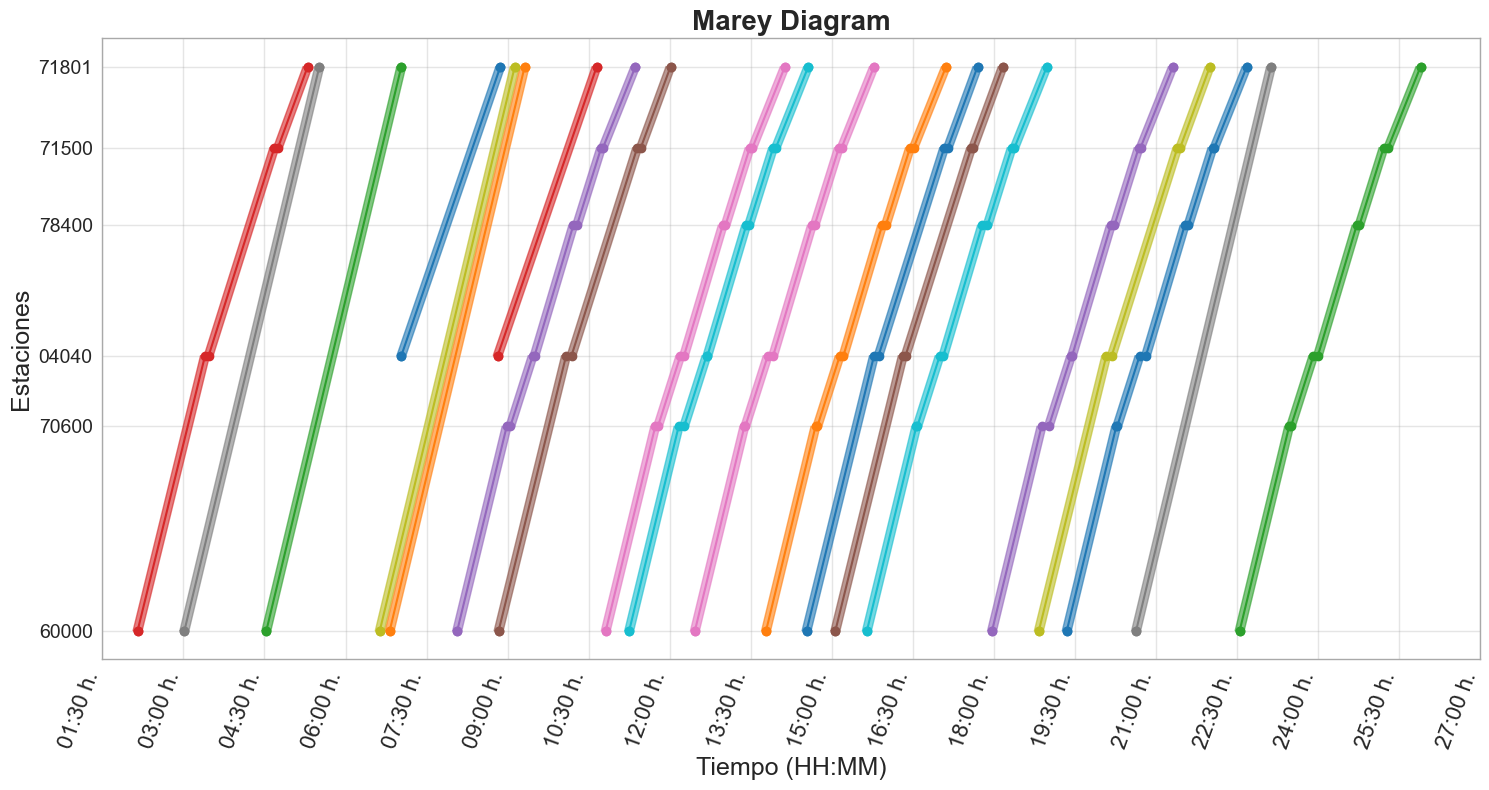

In [26]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

plotter = TrainSchedulePlotter(filtered_services, line)
plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [30]:
sorted_dt = dict(sorted(filtered_services.items(), key=lambda x: tuple(x[1].values())[0][0], reverse=False))
sorted_dt

{'6_2024-06-25-2.10': {'60000': [129, 129],
  '04040': [204, 208],
  '71500': [281, 285],
  '71801': [318, 318]},
 '11_2024-06-25-3.05': {'60000': [181, 181], '71801': [331, 331]},
 '16_2024-06-25-4.33': {'60000': [272, 272], '71801': [422, 422]},
 '12_2024-06-25-6.38': {'60000': [398, 398], '71801': [548, 548]},
 '15_2024-06-25-6.52': {'60000': [409, 409], '71801': [559, 559]},
 '39_2024-06-25-7.04': {'04040': [422, 422], '71801': [532, 532]},
 '7_2024-06-25-8.02': {'60000': [484, 484],
  '70600': [539, 543],
  '04040': [568, 570],
  '78400': [613, 617],
  '71500': [644, 646],
  '71801': [682, 682]},
 '17_2024-06-25-8.47': {'04040': [529, 529], '71801': [639, 639]},
 '8_2024-06-25-8.51': {'60000': [530, 530],
  '04040': [605, 611],
  '71500': [684, 688],
  '71801': [721, 721]},
 '25_2024-06-25-10.49': {'60000': [649, 649],
  '70600': [704, 707],
  '04040': [732, 736],
  '78400': [779, 782],
  '71500': [809, 812],
  '71801': [848, 848]},
 '38_2024-06-25-11.12': {'60000': [675, 675],
  

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [31]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_file,
                path_config_demand=demand_config_path)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'),
                           save_trace=True,
                           departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_file)

kernel_plotter.plotter_data_analysis()

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 3842
	Status: User bought a service which was not the one with the best utility. - Passengers: 3268
	Status: User bought the ticket with best utility. - Passengers: 979
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4247
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 993 - Percentage: 23.38 %
		Seat: Turista - Passengers: 2721 - Percentage: 64.07 %
		Seat: TuristaPlus - Passengers: 533 - Percentage: 12.55 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4247
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 13
			Seat: Turista - Number of tickets sold: 54
			Seat: TuristaPlus - Number of tickets sold: 73
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 10
			Seat: Turista - Number of tic

{'Tourist': {'Turista': 959, 'TuristaPlus': 350, 'Premium': 50}, 'Business': {'Premium': 893, 'Turista': 1259}, 'Student': {'Turista': 503, 'TuristaPlus': 183, 'Premium': 50}}


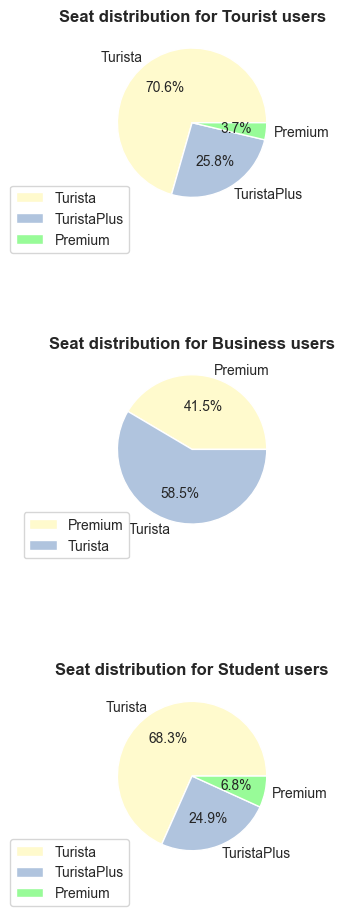

In [32]:
kernel_plotter.plot_users_seat_pie_chart(save_path='../figures/users_seat_pie_chart.pdf')

## Load inference trace

In [33]:
trace_path = Path(f'{robin_save_path}/inference_trace.json')

# Load trace json
with open(trace_path, 'r') as f:
    trace = json.load(f)

In [34]:
# Tickets bought by user pattern

n_pass = {}
for t in trace:
   if trace[t]['user_pattern'] not in n_pass:
       n_pass[trace[t]['user_pattern']] = 1
   else:
       n_pass[trace[t]['user_pattern']] += 1

n_pass

{'Tourist': 1359, 'Business': 2152, 'Student': 736}

## Load user patterns and variables from demand config file

In [35]:
# Load demand config yaml
with open(demand_config_path, 'r') as f:
    demand_config = yaml.safe_load(f)

In [36]:
user_patterns = []
variables = {}

for user_pattern in demand_config['userPattern']:
    user_patterns.append(user_pattern['name'])
    for variable in user_pattern['variables']:
        if variable['name'] not in variables:
            if variable['type'] == 'fuzzy':
                variables[variable['name']] = variable['sets']
            elif variable['type'] == 'categorical':
                variables[variable['name']] = variable['labels']
        else:
            # Assert set matches
            if variable['type'] == 'fuzzy':
                assert variables[variable['name']] == variable['sets']
            elif variable['type'] == 'categorical':
                assert variables[variable['name']] == variable['labels']
                
print(user_patterns)
pprint.pp(variables)

['Business', 'Student', 'Tourist']
{'origin': ['very_near', 'mid_range', 'far', 'far_away'],
 'destination': ['very_near', 'mid_range', 'far', 'far_away'],
 'departure_time': ['in_time', 'close', 'remote', 'very_remote'],
 'arrival_time': ['in_time', 'close', 'remote', 'very_remote'],
 'price': ['very_cheap', 'cheap', 'medium', 'expensive'],
 'seat': ['Turista', 'TuristaPlus', 'Premium'],
 'tsp': ['AVE', 'AVLO', 'OUIGO', 'IRYO']}


In [37]:
# Create dataframes for each behaviour variable

behaviour_dfs = {}
for variable in variables:
    behaviour_dfs[variable] = pd.DataFrame(columns=user_patterns, index=variables[variable])
    
    for variable_set in variables[variable]:
        behaviour_dfs[variable].loc[variable_set] = [np.zeros(3) for _ in range(len(user_patterns))]
    
    print("Variable: ", variable)
    print(behaviour_dfs[variable])

Variable:  origin
                  Business          Student          Tourist
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
Variable:  destination
                  Business          Student          Tourist
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
Variable:  departure_time
                    Business          Student          Tourist
in_time      [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
close        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
remote       [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
very_remote  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
Variable

In [38]:
def update_behaviour_dfs(behaviour_dfs: Mapping[str, pd.DataFrame],
                         user_pattern: str,
                         rules: List):
    passenger_set = set()
    def recurse_elements(element):
        if isinstance(element, dict):
            if 'variable' in element:
                if element['variable'] in behaviour_dfs:
                    set_name_and_values = element['setname_and_values']
                    set_name = set_name_and_values[0] if type(set_name_and_values) is list else set_name_and_values
                    if set_name in behaviour_dfs[element['variable']].index:
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][0] += element['result']
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][1] += 1
                        if (element['variable'], set_name) not in passenger_set:
                            behaviour_dfs[element['variable']].loc[set_name, user_pattern][2] += 1
                            passenger_set.add((element['variable'], set_name))
            for value in element.values():
                recurse_elements(value)
        elif isinstance(element, list):
            for item in element:
                recurse_elements(item)

    for rule in rules:
        recurse_elements(rule)

    return behaviour_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_behaviour_dfs(behaviour_dfs=behaviour_dfs,
                                         user_pattern=user_pattern,
                                         rules=trace[passenger]['trace_of_each_rule'])
    
for var in behaviour_dfs:
    print(f'Variable: {var}')
    display(behaviour_dfs[var])

Variable: origin


,Business,Student,Tourist
very_near,"[4304.0, 4304.0, 2152.0]","[1472.0, 1472.0, 736.0]","[1359.0, 1359.0, 1359.0]"
mid_range,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
far,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
far_away,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: destination


,Business,Student,Tourist
very_near,"[4304.0, 4304.0, 2152.0]","[1472.0, 1472.0, 736.0]","[1359.0, 1359.0, 1359.0]"
mid_range,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1359.0, 1359.0]"
far,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
far_away,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: departure_time


,Business,Student,Tourist
in_time,"[4304.0, 4304.0, 2152.0]","[716.7916666666671, 736.0, 736.0]","[1026.9850000000101, 1359.0, 1359.0]"
close,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[332.0150000000034, 1359.0, 1359.0]"
remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1359.0, 1359.0]"
very_remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: arrival_time


,Business,Student,Tourist
in_time,"[4264.859999999938, 4304.0, 2152.0]","[708.8333333333339, 736.0, 736.0]","[839.3208333333395, 1359.0, 1359.0]"
close,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[519.679166666663, 1359.0, 1359.0]"
remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1359.0, 1359.0]"
very_remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: price


,Business,Student,Tourist
very_cheap,"[0.0, 0.0, 0.0]","[0.0, 607.0, 607.0]","[48.45899999999994, 1359.0, 1359.0]"
cheap,"[0.0, 0.0, 0.0]","[591.6500000000005, 607.0, 607.0]","[1310.5409999999997, 1359.0, 1359.0]"
medium,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
expensive,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: seat


,Business,Student,Tourist
Turista,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1359.0, 1359.0, 1359.0]"
TuristaPlus,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
Premium,"[747.0, 747.0, 747.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: tsp


,Business,Student,Tourist
AVE,"[1181.0, 1181.0, 1181.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
AVLO,"[0.0, 1181.0, 1181.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
OUIGO,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
IRYO,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


In [40]:
# Multicolumn pandas dataframes

for df in behaviour_dfs: 
    values = behaviour_dfs[df].values
    np_vals = np.array([val for row in values for data in row for val in data], dtype=np.float32)
    np_vals = np_vals.reshape(len(behaviour_dfs[df].index), len(behaviour_dfs[df].columns) * len(user_patterns))
    
    midx = pd.MultiIndex.from_product([user_patterns, ['Sum', 'Count', 'Passengers']])
    multicol_df = pd.DataFrame(np_vals, index=behaviour_dfs[df].index, columns=midx)
    display(multicol_df)

Business                    Student                    Tourist  \
               Sum   Count Passengers     Sum   Count Passengers     Sum   
very_near   4304.0  4304.0     2152.0  1472.0  1472.0      736.0  1359.0   
mid_range      0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far            0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far_away       0.0     0.0        0.0     0.0     0.0        0.0     0.0   

                              
            Count Passengers  
very_near  1359.0     1359.0  
mid_range     0.0        0.0  
far           0.0        0.0  
far_away      0.0        0.0

Business                    Student                    Tourist  \
               Sum   Count Passengers     Sum   Count Passengers     Sum   
very_near   4304.0  4304.0     2152.0  1472.0  1472.0      736.0  1359.0   
mid_range      0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far            0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far_away       0.0     0.0        0.0     0.0     0.0        0.0     0.0   

                              
            Count Passengers  
very_near  1359.0     1359.0  
mid_range  1359.0     1359.0  
far           0.0        0.0  
far_away      0.0        0.0

Business                        Student                    \
                 Sum   Count Passengers         Sum  Count Passengers   
in_time       4304.0  4304.0     2152.0  716.791687  736.0      736.0   
close            0.0     0.0        0.0    0.000000    0.0        0.0   
remote           0.0     0.0        0.0    0.000000    0.0        0.0   
very_remote      0.0     0.0        0.0    0.000000    0.0        0.0   

                 Tourist                     
                     Sum   Count Passengers  
in_time      1026.984985  1359.0     1359.0  
close         332.015015  1359.0     1359.0  
remote          0.000000  1359.0     1359.0  
very_remote     0.000000     0.0        0.0

Business                        Student                    \
                     Sum   Count Passengers         Sum  Count Passengers   
in_time      4264.859863  4304.0     2152.0  708.833313  736.0      736.0   
close           0.000000     0.0        0.0    0.000000    0.0        0.0   
remote          0.000000     0.0        0.0    0.000000    0.0        0.0   
very_remote     0.000000     0.0        0.0    0.000000    0.0        0.0   

                Tourist                     
                    Sum   Count Passengers  
in_time      839.320862  1359.0     1359.0  
close        519.679138  1359.0     1359.0  
remote         0.000000  1359.0     1359.0  
very_remote    0.000000     0.0        0.0

Business                      Student                    \
                Sum Count Passengers         Sum  Count Passengers   
very_cheap      0.0   0.0        0.0    0.000000  607.0      607.0   
cheap           0.0   0.0        0.0  591.650024  607.0      607.0   
medium          0.0   0.0        0.0    0.000000    0.0        0.0   
expensive       0.0   0.0        0.0    0.000000    0.0        0.0   

                Tourist                     
                    Sum   Count Passengers  
very_cheap    48.459000  1359.0     1359.0  
cheap       1310.541016  1359.0     1359.0  
medium         0.000000     0.0        0.0  
expensive      0.000000     0.0        0.0

Business                   Student                  Tourist  \
                 Sum  Count Passengers     Sum Count Passengers     Sum   
Turista          0.0    0.0        0.0     0.0   0.0        0.0  1359.0   
TuristaPlus      0.0    0.0        0.0     0.0   0.0        0.0     0.0   
Premium        747.0  747.0      747.0     0.0   0.0        0.0     0.0   

                                
              Count Passengers  
Turista      1359.0     1359.0  
TuristaPlus     0.0        0.0  
Premium         0.0        0.0

Business                    Student                  Tourist        \
           Sum   Count Passengers     Sum Count Passengers     Sum Count   
AVE     1181.0  1181.0     1181.0     0.0   0.0        0.0     0.0   0.0   
AVLO       0.0  1181.0     1181.0     0.0   0.0        0.0     0.0   0.0   
OUIGO      0.0     0.0        0.0     0.0   0.0        0.0     0.0   0.0   
IRYO       0.0     0.0        0.0     0.0   0.0        0.0     0.0   0.0   

                  
      Passengers  
AVE          0.0  
AVLO         0.0  
OUIGO        0.0  
IRYO         0.0